In [1]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TSLA", "JPM", "BAC", "C", "WFC", "GS",
          "JNJ", "UNH", "PFE", "ABT", "CVS", "KO", "PG", "WMT", "CLX", "PEP",
          "CAT", "BA", "HON", "RTX", "MMM", "XOM", "CVX", "SLB", "EOG", "APA",
          "NEE", "DUK", "EXC", "D", "SHW", "LIN", "VALE", "NUE", "CCL", "SPHD",
          "VNQ", "XRE", "IYR", "IEF", "FB", "HD", "DIS", "NFLX", "PYPL", "CRM", 
          "INTC", "AMD", "MU", "META", "BK", "WBA", "COST", "LOW", "NVDA"]

tick = ' '.join(item for item in tickers)

In [2]:
import yfinance as yf
import pandas as pd

tickers_combined = yf.Tickers(tick)
l = ['trailingPE', 'profitMargins', 'shortPercentOfFloat', 'currentRatio', 'returnOnAssets']
data = pd.DataFrame()

for i in tickers:
    temp = tickers_combined.tickers[f"{i}"].info
    temp_d = {k:temp[k] for k in l if k in temp}
    temp_d["ticker"] = f"{i}"

    temp_df = pd.Series(temp_d)
    data = pd.concat([data, temp_df], axis=1)

In [3]:
data_T = data.T
data_T.dropna(inplace=True)
data_T.set_index('ticker', inplace=True)

In [4]:
from sklearn.decomposition import PCA 
from sklearn import preprocessing

scaled_data = preprocessing.scale(data_T)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

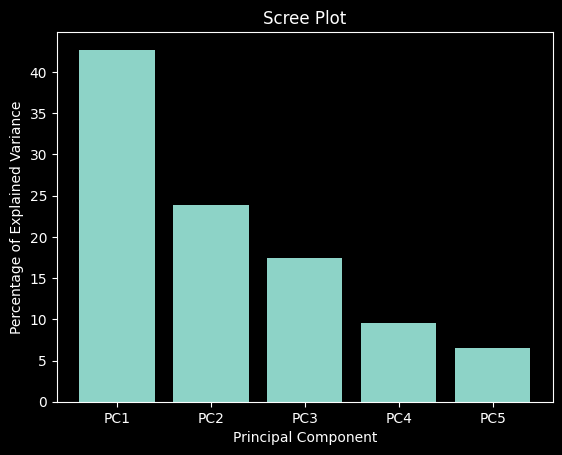

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
plt.style.use('dark_background')

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1) # percentage variance
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Component")
plt.title("Scree Plot")
plt.show();

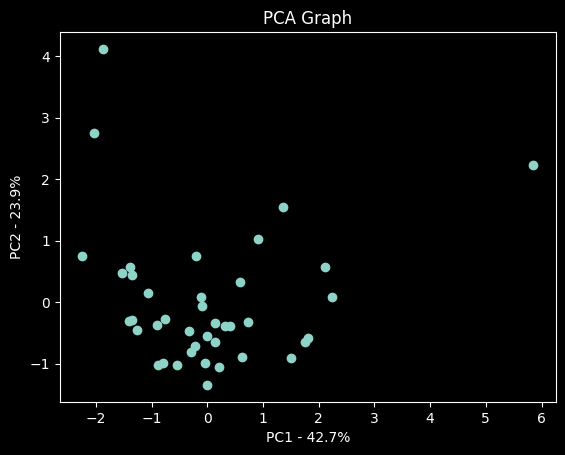

In [6]:
pca_df = pd.DataFrame(pca_data, index=[data_T.index.values], columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("PCA Graph")
plt.xlabel(f"PC1 - {per_var[0]}%")
plt.ylabel(f"PC2 - {per_var[1]}%")

# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show();

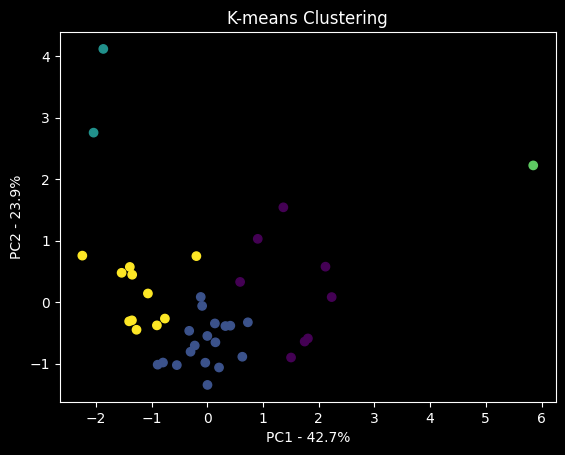

In [7]:
from sklearn.cluster import KMeans

n_clusters=5
kmeans = KMeans(n_init=3, n_clusters=n_clusters, random_state=0)
km_data = pca_df.drop(["PC3", "PC4", "PC5"], axis=1)

kmeans.fit(km_data)

labels = kmeans.labels_

plt.scatter(pca_df.PC1, pca_df.PC2, c=labels)
plt.title("K-means Clustering")
plt.xlabel(f"PC1 - {per_var[0]}%")
plt.ylabel(f"PC2 - {per_var[1]}%")
plt.show();

In [8]:
km_data["Cluster"] = kmeans.labels_

portfolio = []
for i in range(n_clusters):
    temp = km_data[km_data["Cluster"] == i]
    asset = temp.iloc[np.random.randint(0, len(temp))]
    portfolio.append(asset.name[0])

print(portfolio)

['META', 'SLB', 'AMD', 'NVDA', 'COST']


In [9]:
port_tick = ' '.join(item for item in portfolio)

port_tick_combined = yf.Tickers(port_tick)

a1 = port_tick_combined.tickers[portfolio[0]].history(period='1y')["Close"]
a2 = port_tick_combined.tickers[portfolio[1]].history(period='1y')["Close"]
a3 = port_tick_combined.tickers[portfolio[2]].history(period='1y')["Close"]
a4 = port_tick_combined.tickers[portfolio[3]].history(period='1y')["Close"]
a5 = port_tick_combined.tickers[portfolio[4]].history(period='1y')["Close"]

In [10]:
corr = np.corrcoef([a1, a2, a3, a4, a5])
L = np.linalg.cholesky(corr)

In [11]:
log_ret_a1 = a1.div(a1.shift(1)).dropna().apply(np.log)
# log_ret_a1 = a1.pct_change().dropna()
a1_mean = np.mean(log_ret_a1)
a1_sd = np.std(log_ret_a1)

log_ret_a2 = a2.div(a2.shift(1)).dropna().apply(np.log)
# log_ret_a2 = a2.pct_change().dropna()
a2_mean = np.mean(log_ret_a2)
a2_sd = np.std(log_ret_a2)

log_ret_a3 = a3.div(a3.shift(1)).dropna().apply(np.log)
# log_ret_a3 = a3.pct_change().dropna()
a3_mean = np.mean(log_ret_a3)
a3_sd = np.std(log_ret_a3)

log_ret_a4 = a4.div(a4.shift(1)).dropna().apply(np.log)
# log_ret_a4 = a4.pct_change().dropna()
a4_mean = np.mean(log_ret_a4)
a4_sd = np.std(log_ret_a4)

log_ret_a5 = a5.div(a5.shift(1)).dropna().apply(np.log)
# log_ret_a5 = a5.pct_change().dropna()
a5_mean = np.mean(log_ret_a5)
a5_sd = np.std(log_ret_a5)

combined_sd = np.array([a1_sd, a2_sd, a3_sd, a4_sd, a5_sd])
combined_means = np.array([a1_mean, a2_mean, a3_mean, a4_mean, a5_mean])

for portfolio with unoptimised weights:~
mean of returns: 0.7461707916475716
std. dev. of returns: 0.4443882769139763
sharpe ratio 1.4540680418818877


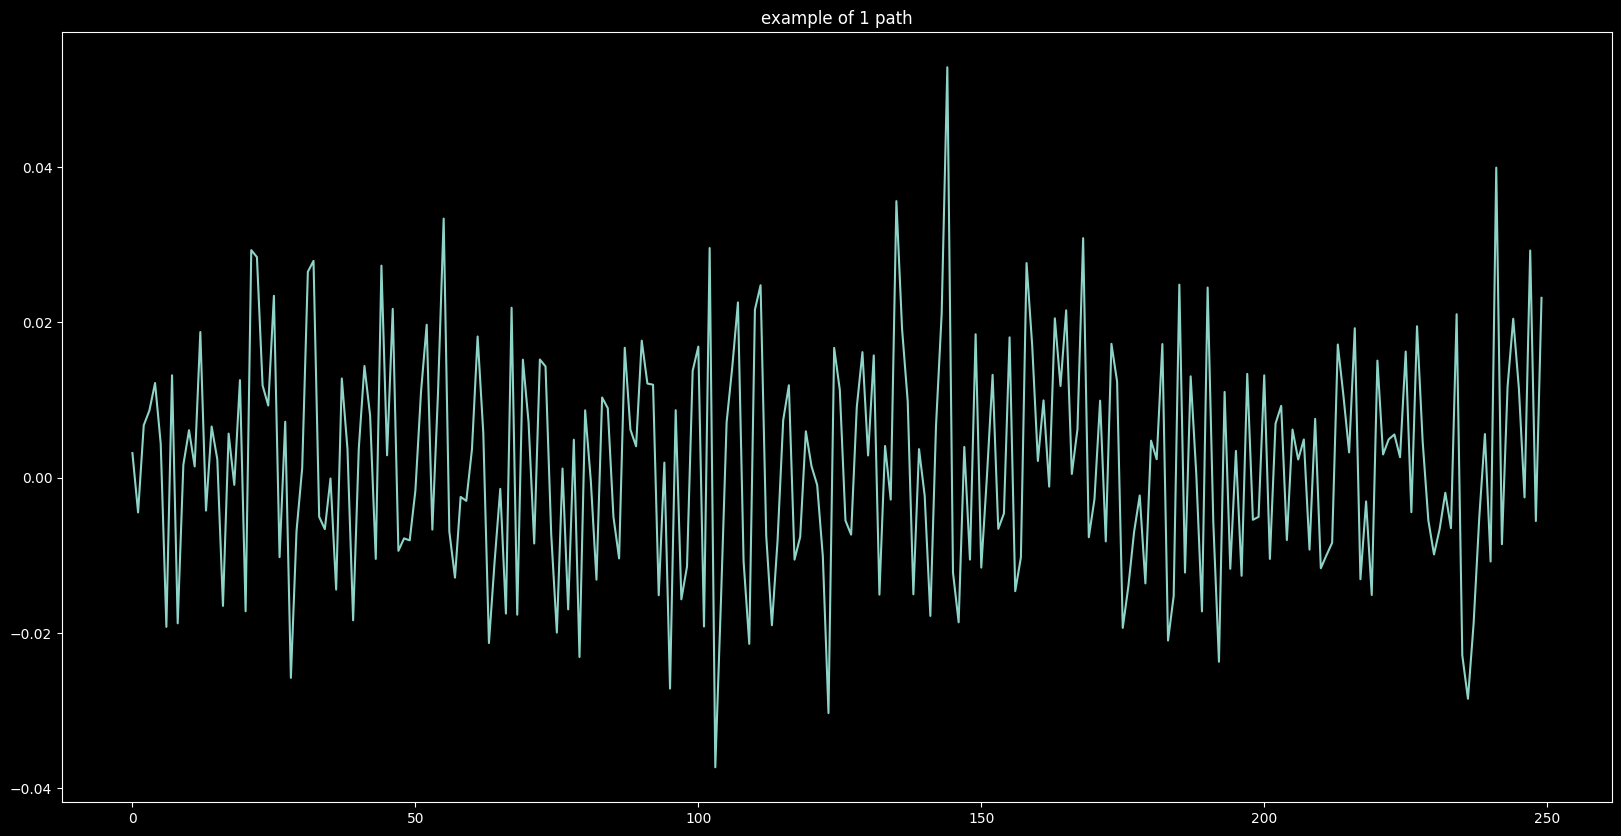

In [12]:
weights = [0.1, 0.3, 0.2, 0.1, 0.3]
total_returns = []

fig, ax = plt.subplots(figsize = (20,10))

for i in range(1000):
    portfolio_returns = []
    for i in range(250): # this simulates performance over 1 year
        rand_vals = np.random.normal(0, 1, 5)
        corr_rand_vals = L @ rand_vals
        daily_sim_returns = sum(weights * (np.exp(corr_rand_vals * combined_sd + combined_means) - 1))
        portfolio_returns.append(daily_sim_returns)

    total_returns.append(np.prod(np.array(portfolio_returns)+1))

mean = np.mean(np.array(total_returns)-1)
sd = np.std(np.array(total_returns)-1)

print("for portfolio with unoptimised weights:~")
print(f"mean of returns: {mean}")
print(f"std. dev. of returns: {sd}")
print(f"sharpe ratio {(mean - 0.1)/sd}")

ax.plot([i for i in range(len(portfolio_returns))], portfolio_returns)
ax.title.set_text("example of 1 path")
plt.show()

In [13]:
w1 = 0.1
w2 = 0.3
w3 = 0.2
w4 = 0.1
w5 = 0.3

weights = np.array([w1, w2, w3, w4, w5])
assets = [log_ret_a1, log_ret_a2, log_ret_a3, log_ret_a4, log_ret_a5]

def portfolio_var(w, ret, csd):
    n = len(ret)
    cov_part = 0

    for i in range(n):
        for j in range(i+1, n):
            cov_part += 2*w[i]*w[j]*np.cov(ret[i], ret[j])[0,1]
    
    return (sum([(i**2)*(j**2) for i,j in zip(w, csd)]) + cov_part)

portfolio_var([w1, w2, w3, w4, w5], assets, combined_sd), np.dot(np.dot(weights, np.cov(assets)), weights.T)

(0.00015835343540362864, 0.00015873960434279616)

In [14]:
from scipy.optimize import minimize
cons = ({'type':'eq', 'fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]-1})

weights_optim = minimize(fun = portfolio_var, x0 = [0.0, 0.0, 0.0, 0.0, 0.0], args = (assets, combined_sd), constraints = cons, method = 'SLSQP')
optimal_weights = list(weights_optim.x)

In [15]:
optimal_weights

[0.20000000000036983,
 0.2000000000015667,
 0.1999999999954378,
 0.199999999996237,
 0.20000000000638854]

In [16]:
total_returns = []

# re-running the monte carlo simulation
for i in range(1000):
    portfolio_returns = []
    for i in range(250): 
        rand_vals = np.random.normal(0, 1, 5)
        corr_rand_vals = L @ rand_vals
        daily_sim_returns = sum(optimal_weights * (np.exp(corr_rand_vals * combined_sd + combined_means) - 1)) 
        portfolio_returns.append(daily_sim_returns)

    total_returns.append(np.prod(np.array(portfolio_returns)+1))

mean = np.mean(np.array(total_returns)-1)
sd = np.std(np.array(total_returns)-1)

print("for portfolio with *optimised* weights:~")
print(f"mean of returns: {mean}")
print(f"std. dev. of returns: {sd}")
print(f"sharpe ratio {(mean - 0.1)/sd}")

for portfolio with *optimised* weights:~
mean of returns: 1.135628029485344
std. dev. of returns: 0.6308475446019285
sharpe ratio 1.6416454947745516
